# Task 4: Autoencoder
Dmytro Geleshko

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras
from keras import layers

from sklearn import metrics

## TF Config

In [2]:
tf.test.is_built_with_cuda()

True

In [3]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Data
### Loading

In [4]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

print("Train X:", X_train.shape, X_train.dtype)
print("Train y:", y_train.shape, y_train.dtype)
print("Test X:", X_test.shape, X_test.dtype)
print("Test y:", y_test.shape, y_test.dtype)

Train X: (60000, 28, 28) uint8
Train y: (60000,) uint8
Test X: (10000, 28, 28) uint8
Test y: (10000,) uint8


### Preview

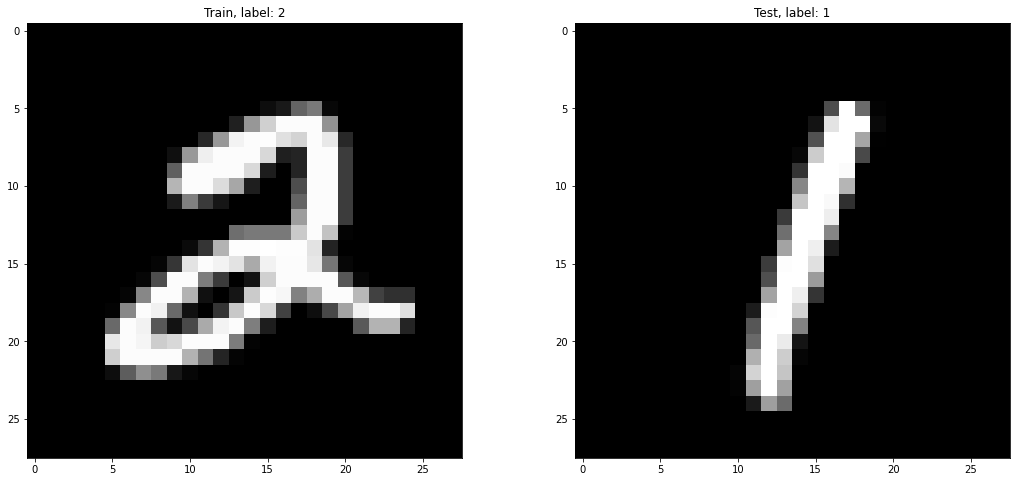

In [5]:
example = 5
plt.rcParams["figure.figsize"] = (18, 8)

plt.subplot(1, 2, 1)
plt.imshow(X_train[example], "gray")
plt.title("Train, label: " + str(y_train[example]))

plt.subplot(1, 2, 2)
plt.imshow(X_test[example], "gray")
plt.title("Test, label: " + str(y_test[example]))

plt.show()

### Reshape and Cast

In [6]:
X_train = (X_train.reshape(-1, 28 * 28) / 255).astype(np.float32)
X_test = (X_test.reshape(-1, 28 * 28) / 255).astype(np.float32)


print("Train X:", X_train.shape, X_train.dtype)
print("Test X:", X_test.shape, X_test.dtype)

Train X: (60000, 784) float32
Test X: (10000, 784) float32


### Introducing noise

In [ ]:
def add_noise(data, mean, std, min_clip, max_clip):
    return np.clip(
        data + np.random.normal(mean, std, size=data.shape),
        a_min=min_clip, a_max=max_clip, dtype=np.float32)

In [7]:
X_train_noise = add_noise(X_train, mean=0, std=0.2, min_clip=0, max_clip=1)
X_test_noise = add_noise(X_test, mean=0, std=0.2, min_clip=0, max_clip=1)

### Preview

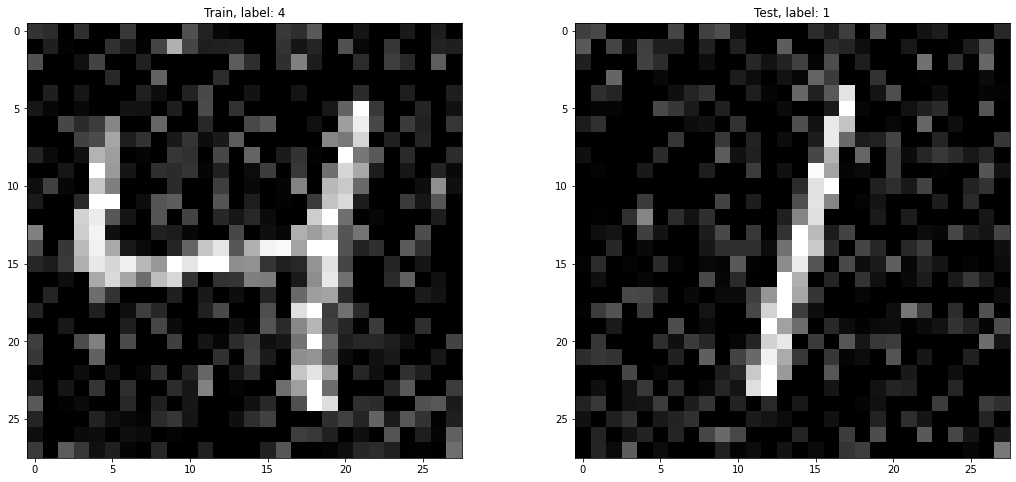

In [8]:
example = 2
plt.rcParams["figure.figsize"] = (18, 8)

plt.subplot(1, 2, 1)
plt.imshow(X_train_noise[example].reshape(28, 28), "gray")
plt.title("Train, label: " + str(y_train[example]))

plt.subplot(1, 2, 2)
plt.imshow(X_test_noise[example].reshape(28, 28), "gray")
plt.title("Test, label: " + str(y_test[example]))

plt.show()

## Autoencoder
### Architecture

In [9]:
def build_autoencoder(input_shape, hidden, code):
    X_in = keras.Input(input_shape)

    X = layers.Dense(hidden, activation="relu")(X_in)

    X = layers.Dense(code, activation="relu")(X)

    X = layers.Dense(hidden, activation="relu")(X)

    X = layers.Dense(input_shape, activation="sigmoid")(X)
    
    return keras.Model(inputs=X_in, outputs=X)

In [10]:
autoencoder = build_autoencoder(784, 128, 32)
print(autoencoder.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dense_2 (Dense)             (None, 128)               4224      
                                                                 
 dense_3 (Dense)             (None, 784)               101136    
                                                                 
Total params: 209,968
Trainable params: 209,968
Non-trainable params: 0
_________________________________________________________________
None


In [11]:
autoencoder.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss=keras.losses.BinaryCrossentropy()
)

### Train

In [12]:
autoencoder_history = autoencoder.fit(X_train_noise, X_train, batch_size=32, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 7s 3ms/step - loss: 0.2330
Epoch 2/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1514
Epoch 3/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1345
Epoch 4/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1262
Epoch 5/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1202


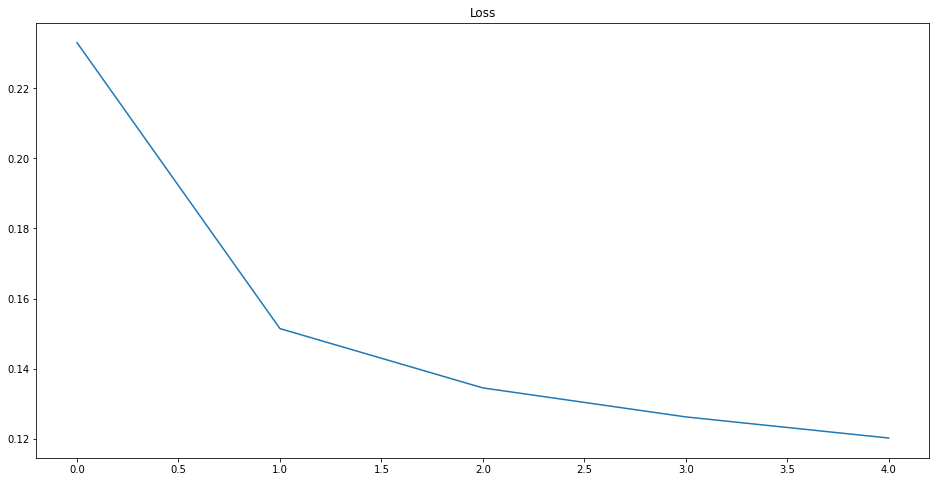

In [13]:
plt.rcParams["figure.figsize"] = (16, 8)
plt.plot(autoencoder_history.history["loss"])
plt.title("Loss")

plt.show()

### Denoised data

In [17]:
X_test_denoised = autoencoder.predict(X_test_noise)

### Preview

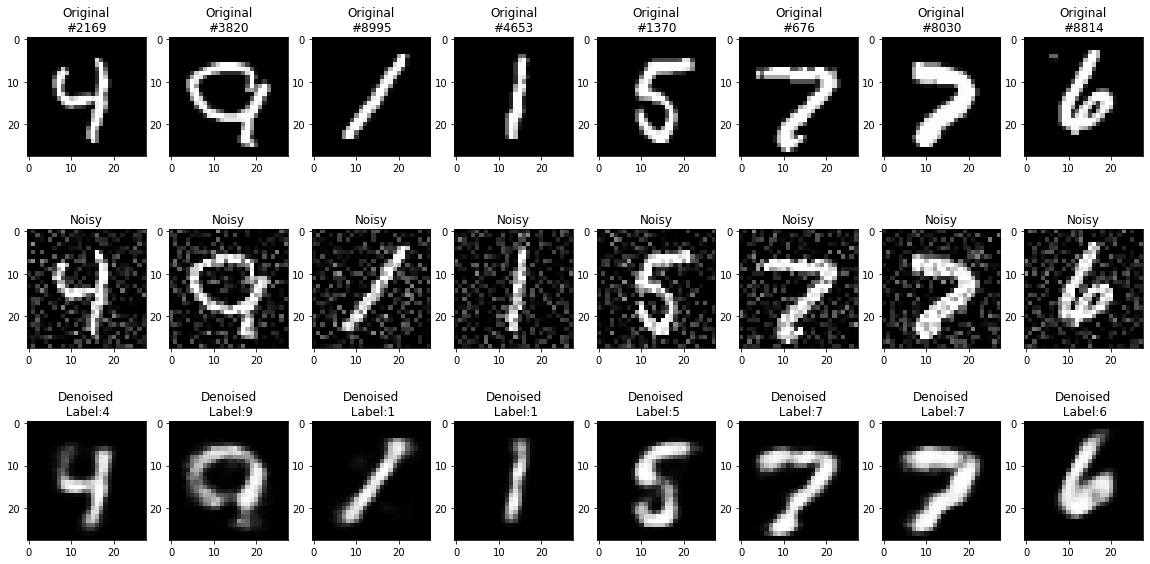

In [20]:
plt.rcParams["figure.figsize"] = (20, 10)
for i in range(8):
    random_example = np.random.randint(0, X_test_noise.shape[0])
    
    plt.subplot(3, 8, i + 1)
    plt.imshow(X_test[random_example].reshape(28, 28), "gray")
    plt.title("Original\n#" + str(random_example))

    plt.subplot(3, 8, i + 9)
    plt.imshow(X_test_noise[random_example].reshape(28, 28), "gray")
    plt.title("Noisy")

    plt.subplot(3, 8, i + 17)
    plt.imshow(X_test_denoised[random_example].reshape(1, 784).reshape(28, 28), "gray")
    plt.title("Denoised\n Label:" + str(y_test[random_example]))

### Save

In [21]:
autoencoder.save("models/autoencoder")

INFO:tensorflow:Assets written to: models/autoencoder\assets


## Model

### Architecture

In [22]:
def build_model(input_shape, n_classes):
    X_in = keras.Input(input_shape)

    X = layers.Dense(256, activation="relu")(X_in)

    X = layers.Dense(128, activation="relu")(X)

    X = layers.Dense(64, activation="relu")(X)

    X = layers.Dense(n_classes, activation="softmax")(X)
    
    return keras.Model(inputs=X_in, outputs=X)

In [23]:
model = build_model(784, 10)
print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_4 (Dense)             (None, 256)               200960    
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 10)                650       
                                                                 
Total params: 242,762
Trainable params: 242,762
Non-trainable params: 0
_________________________________________________________________
None


In [24]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
)

### Train

In [25]:
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_split=0.05, validation_batch_size=32)

Epoch 1/10
1782/1782 [==============================] - 6s 3ms/step - loss: 0.4642 - sparse_categorical_accuracy: 0.8721 - val_loss: 0.1557 - val_sparse_categorical_accuracy: 0.9630
Epoch 2/10
1782/1782 [==============================] - 6s 3ms/step - loss: 0.1810 - sparse_categorical_accuracy: 0.9485 - val_loss: 0.1074 - val_sparse_categorical_accuracy: 0.9740
Epoch 3/10
1782/1782 [==============================] - 6s 3ms/step - loss: 0.1331 - sparse_categorical_accuracy: 0.9617 - val_loss: 0.0896 - val_sparse_categorical_accuracy: 0.9793
Epoch 4/10
1782/1782 [==============================] - 6s 3ms/step - loss: 0.1044 - sparse_categorical_accuracy: 0.9699 - val_loss: 0.0851 - val_sparse_categorical_accuracy: 0.9773
Epoch 5/10
1782/1782 [==============================] - 6s 3ms/step - loss: 0.0845 - sparse_categorical_accuracy: 0.9752 - val_loss: 0.0744 - val_sparse_categorical_accuracy: 0.9803
Epoch 6/10
1782/1782 [==============================] - 6s 4ms/step - loss: 0.0698 - spars

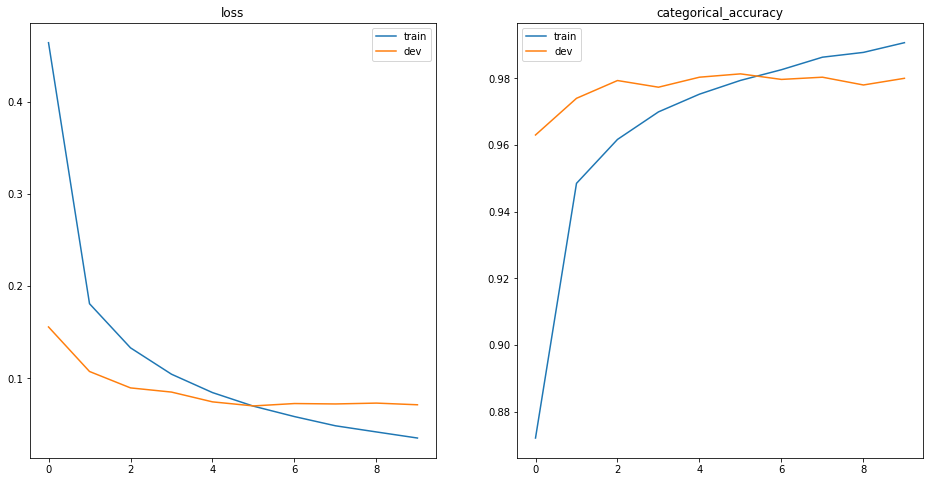

In [26]:
plt.rcParams["figure.figsize"] = (16, 8)
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="dev")
plt.legend()
plt.title("loss")

plt.subplot(1, 2, 2)
plt.plot(history.history["sparse_categorical_accuracy"], label="train")
plt.plot(history.history["val_sparse_categorical_accuracy"], label="dev")
plt.legend()
plt.title("categorical_accuracy")

plt.show()

### Save

In [27]:
model.save("models/nn")

INFO:tensorflow:Assets written to: models/nn\assets


## Comparing
### Evaluate

In [28]:
print("Standart:", model.evaluate(X_test, y_test, verbose=0))
print("Noisy:", model.evaluate(X_test_noise, y_test, verbose=0))
print("Denoised:", model.evaluate(X_test_denoised, y_test, verbose=0))

Standart: [0.07202868163585663, 0.9779999852180481]
Noisy: [0.6226099133491516, 0.7997000217437744]
Denoised: [0.18491947650909424, 0.9426000118255615]


### Classification Report

In [ ]:
y_hat = np.argmax(model.predict(X_test), axis=-1)
y_hat_noise = np.argmax(model.predict(X_test_noise), axis=-1)
y_hat_denoised = np.argmax(model.predict(X_test_denoised), axis=-1)

In [ ]:
print("Standart:")
print(metrics.classification_report(y_test, y_hat, target_names=[str(x) for x in range(0, 10)]))
print("\nNoise:")
print(metrics.classification_report(y_test, y_hat_noise, target_names=[str(x) for x in range(0, 10)]))
print("\nDenoised:")
print(metrics.classification_report(y_test, y_hat_denoised, target_names=[str(x) for x in range(0, 10)]))

## Inference Example
### Load the autoencoder

In [ ]:
loaded_autoencoder = tf.keras.models.load_model("models/autoencoder")

### Load the example

In [ ]:
example = 5

In [ ]:
(_, _), (infer_x, infer_y) = keras.datasets.mnist.load_data()

infer_x = (infer_x[example].reshape(1, -1) / 255).astype(np.float32)
infer_y = infer_y[example]

In [ ]:
infer_x_noise = add_noise(infer_x, mean=0, std=0.2, min_clip=0, max_clip=1)

### Infer

In [ ]:
infer_x_denoised = loaded_autoencoder.predict(infer_x)

### Preview

In [ ]:
plt.rcParams["figure.figsize"] = (18, 6)

plt.subplot(1, 3, 1)
plt.imshow(infer_x.reshape(28, 28), "gray")
plt.title("Original\n#" + str(example))
plt.subplot(1, 3, 2)
plt.imshow(infer_x_noise.reshape(28, 28), "gray")
plt.title("Noisy")
plt.subplot(1, 3, 3)
plt.imshow(infer_x_denoised.reshape(1, 784).reshape(28, 28), "gray")
plt.title("Denoised\n Label:" + str(infer_y))